## EDA_Part

In [1]:
"""Environment setting"""
import pandas as pd
import numpy as np 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
import gc
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
# to ignore future warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
from catboost import CatBoostRegressor

In [2]:
"""Load dataset"""
train_df = pd.read_csv('../input/train.csv', parse_dates=['first_active_month'])
test_df = pd.read_csv('../input/test.csv', parse_dates=['first_active_month'])
target = train_df['target']
train_df.drop(columns=['target'],inplace=True)
# del train_df['target']
print("{} observations and {} features in train set.".format(train_df.shape[0],train_df.shape[1]))
print("{} observations and {} features in test set.".format(test_df.shape[0],test_df.shape[1]))
# submission_df = pd.read_csv('../input/sample_submission.csv')

201917 observations and 5 features in train set.
123623 observations and 5 features in test set.


In [3]:
display(train_df.head(3))
display(test_df.head(3))
display(train_df.describe())
test_df.describe()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-06-01,C_ID_92a2005557,5,2,1
1,2017-01-01,C_ID_3d0044924f,4,1,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1


,feature_1,feature_2,feature_3
count,201917.000000,201917.000000,201917.000000
mean,3.105311,1.745410,0.565569
std,1.186160,0.751362,0.495683
min,1.000000,1.000000,0.000000
25%,2.000000,1.000000,0.000000
50%,3.000000,2.000000,1.000000
75%,4.000000,2.000000,1.000000
max,5.000000,3.000000,1.000000


,feature_1,feature_2,feature_3
count,123623.00000,123623.000000,123623.000000
mean,3.10926,1.741796,0.564377
std,1.18911,0.749195,0.495840
min,1.00000,1.000000,0.000000
25%,2.00000,1.000000,0.000000
50%,3.00000,2.000000,1.000000
75%,4.00000,2.000000,1.000000
max,5.00000,3.000000,1.000000


ValueError: Could not interpret input 'target'

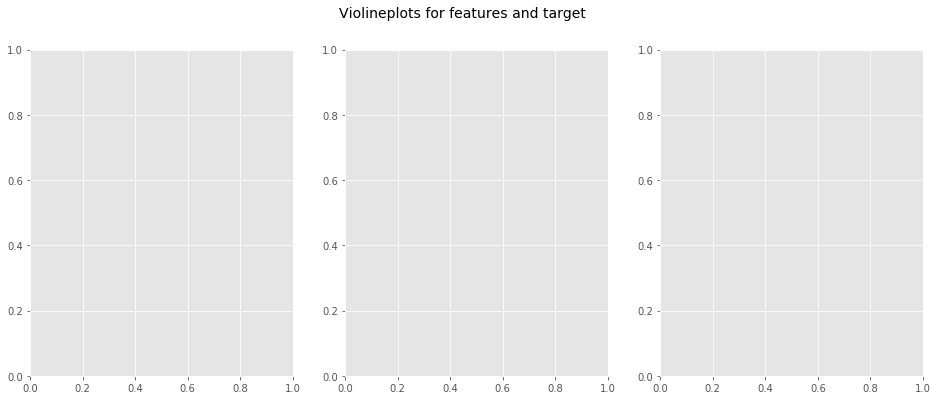

In [4]:
"""Violineplots for feature1/2/3 and target"""
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Violineplots for features and target',fontsize=14) # Add a centered title to the figure.
sns.violinplot(x="feature_1", y="target", data=train_df, ax=ax[0], title='feature_1')
sns.violinplot(x="feature_2", y="target", data=train_df, ax=ax[1], title='feature_2')
sns.violinplot(x="feature_3", y="target", data=train_df, ax=ax[2], title='feature_3')

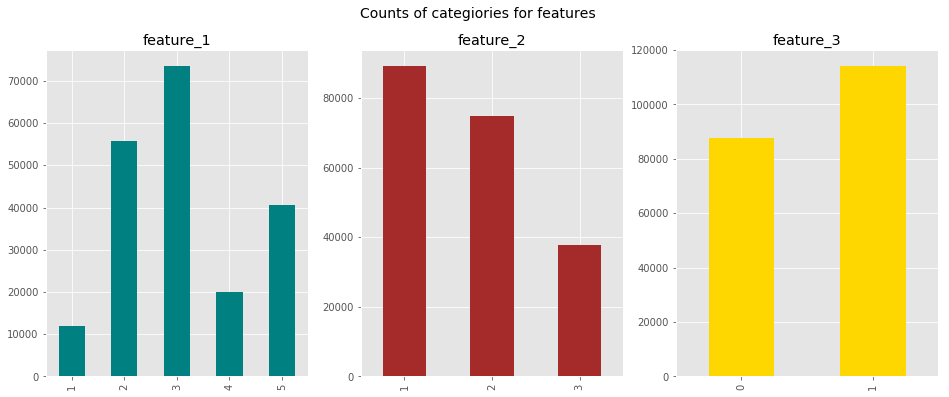

In [5]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
plt.suptitle('Counts of categiories for features',fontsize=14)
train_df['feature_1'].value_counts().sort_index().plot(kind='bar', ax=ax[0], color='teal', title='feature_1')
train_df['feature_2'].value_counts().sort_index().plot(kind='bar', ax=ax[1], color='brown', title='feature_2')
train_df['feature_3'].value_counts().sort_index().plot(kind='bar', ax=ax[2], color='gold', title='feature_3')

**Above two plots implied that although different categories and counts  of these thress features, the distribution of target similar, which means that these features are not good for prediction. Extra features need be mined.  Meanwhile, it is worth noticing that the average target values in each catogory is around zero, which implies that the data were sampled from normal distribution.**"

In [6]:
"""Target Distribution"""
plt.figure(figsize=(12, 5))
plt.hist(train_df.target.values, bins=200)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'target'

<Figure size 864x360 with 0 Axes>

In [7]:
print('There are {0} samples with target lower than -20.'.format(train_df.loc[train_df.target < -20].shape[0]))

AttributeError: 'DataFrame' object has no attribute 'target'

**And there is 1 unique value: -33.21928095. This seems to be a special case. Maybe it would be reasonable to simply exclude these samples. Can have a try.**

In [8]:
"""first_active_month distribution"""
d1 = train_df['first_active_month'].value_counts().sort_index()
d2 = test_df['first_active_month'].value_counts().sort_index()
data = [go.Scatter(x=d1.index, y=d1.values, name='train'), go.Scatter(x=d2.index, y=d2.values, name='test')]
layout = go.Layout(dict(title = "First_active_month distribution",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Count'),
                  ),legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

**Trends of first active month for train and test data are similar, and this is great. Why there is such a sharp decline at the end of the period? I think it was on purpose. Or maybe new cards are taken into account only after fulfilling some conditions.**

In [9]:
"""There is one line with 'first_active_month' missing.
Fill in with the earliest data, having the same values of features."""
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null datetime64[ns]
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 4.7+ MB


In [10]:
test_df.loc[test['first_active_month'].isna(), 'first_active_month'] = test_df.loc[(test_df['feature_1'] == 5) & (test_df['feature_2'] == 2) & (test_df['feature_3'] == 1), 'first_active_month'].min()

NameError: name 'test' is not defined

## Feature Engineer

In [11]:
"""Load extra data"""
new_transactions = pd.read_csv('../input/new_merchant_transactions.csv',
                               parse_dates=['purchase_date'])

historical_transactions = pd.read_csv('../input/historical_transactions.csv',
                                      parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [12]:
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,12
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,12
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,12
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,12
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,12


In [13]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# One-hot encoding
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

# Filter unauthorized transactions
authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


Follow https://www.kaggle.com/denzo123/a-closer-look-at-date-variables , define some new features

In [14]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [15]:
def aggregate_transactions(history):
    """Aggregate the info contained in these two tables. 
    The first function aggregates the function by grouping on card_id"""
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
# history[:5]

authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
# authorized[:5]

new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
# new[:5]

In [16]:
def aggregate_per_month(history):
    """
    The second function first aggregates on the two variables card_id and month_lag. 
    Then a second grouping is performed to aggregate over time:
    """
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group =  aggregate_per_month(authorized_transactions) 
# final_group[:10]

In [17]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

**Training the model**<br>
We now train the model with the features we previously defined. A first step consists in merging all the dataframes:

In [18]:
train_df = pd.merge(train_df, history, on='card_id', how='left')
test_df = pd.merge(test_df, history, on='card_id', how='left')

train_df = pd.merge(train_df, authorized, on='card_id', how='left')
test_df = pd.merge(test_df, authorized, on='card_id', how='left')

train_df = pd.merge(train_df, new, on='card_id', how='left')
test_df = pd.merge(test_df, new, on='card_id', how='left')

train_df = pd.merge(train_df, final_group, on='card_id', how='left')
test_df = pd.merge(test_df, final_group, on='card_id', how='left')

train_df = pd.merge(train_df, auth_mean, on='card_id', how='left')
test_df = pd.merge(test_df, auth_mean, on='card_id', how='left')

train_df = pd.merge(train_df, additional_fields, on='card_id', how='left')
test_df = pd.merge(test_df, additional_fields, on='card_id', how='left')

features = [c for c in train_df.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

We now train the model. Here, we use a standard KFold split of the dataset in order to validate the results and to stop the training. Interstingly, during the writing of this kernel, the model was enriched adding new features, which improved the CV score. The variations observed on the CV were found to be quite similar to the variations on the LB: it seems that the current competition won't give us headaches to define the correct validation scheme:

In [19]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features],
                           label = target.iloc[trn_idx],
                           categorical_feature = categorical_feats
                          )
    val_data = lgb.Dataset(train_df.iloc[val_idx][features],
                           label = target.iloc[val_idx],
                           categorical_feature = categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7148	valid_1's rmse: 3.77645
[200]	training's rmse: 3.64626	valid_1's rmse: 3.72948
[300]	training's rmse: 3.60262	valid_1's rmse: 3.70631
[400]	training's rmse: 3.57136	valid_1's rmse: 3.69349
[500]	training's rmse: 3.54818	valid_1's rmse: 3.68662
[600]	training's rmse: 3.52952	valid_1's rmse: 3.68204
[700]	training's rmse: 3.51425	valid_1's rmse: 3.67953
[800]	training's rmse: 3.49979	valid_1's rmse: 3.67754
[900]	training's rmse: 3.48602	valid_1's rmse: 3.67624
[1000]	training's rmse: 3.47406	valid_1's rmse: 3.67531
[1100]	training's rmse: 3.46236	valid_1's rmse: 3.67454
[1200]	training's rmse: 3.45071	valid_1's rmse: 3.67401
[1300]	training's rmse: 3.44008	valid_1's rmse: 3.67386
[1400]	training's rmse: 3.42923	valid_1's rmse: 3.67345
[1500]	training's rmse: 3.41934	valid_1's rmse: 3.67318
[1600]	training's rmse: 3.40929	valid_1's rmse: 3.67271
[1700]	training's rmse: 3.39925	valid_1's rmse: 3.6

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73216	valid_1's rmse: 3.70614
[200]	training's rmse: 3.66149	valid_1's rmse: 3.66132
[300]	training's rmse: 3.61787	valid_1's rmse: 3.64022
[400]	training's rmse: 3.58634	valid_1's rmse: 3.62983
[500]	training's rmse: 3.56279	valid_1's rmse: 3.62443
[600]	training's rmse: 3.54379	valid_1's rmse: 3.62101
[700]	training's rmse: 3.52746	valid_1's rmse: 3.61875
[800]	training's rmse: 3.51252	valid_1's rmse: 3.61745
[900]	training's rmse: 3.49895	valid_1's rmse: 3.61633
[1000]	training's rmse: 3.48699	valid_1's rmse: 3.61566
[1100]	training's rmse: 3.47515	valid_1's rmse: 3.61489
[1200]	training's rmse: 3.46369	valid_1's rmse: 3.61482
[1300]	training's rmse: 3.45364	valid_1's rmse: 3.61454
[1400]	training's rmse: 3.44314	valid_1's rmse: 3.61419
[1500]	training's rmse: 3.43249	valid_1's rmse: 3.61437
[1600]	training's rmse: 3.42345	valid_1's rmse: 3.61431
Early stopping, best iteration is:
[1430]	training

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73572	valid_1's rmse: 3.68078
[200]	training's rmse: 3.66474	valid_1's rmse: 3.63969
[300]	training's rmse: 3.62053	valid_1's rmse: 3.62065
[400]	training's rmse: 3.58898	valid_1's rmse: 3.61118
[500]	training's rmse: 3.56444	valid_1's rmse: 3.60591
[600]	training's rmse: 3.54454	valid_1's rmse: 3.60247
[700]	training's rmse: 3.52838	valid_1's rmse: 3.60052
[800]	training's rmse: 3.5139	valid_1's rmse: 3.5991
[900]	training's rmse: 3.49986	valid_1's rmse: 3.59831
[1000]	training's rmse: 3.48695	valid_1's rmse: 3.59781
[1100]	training's rmse: 3.47485	valid_1's rmse: 3.59726
[1200]	training's rmse: 3.46385	valid_1's rmse: 3.5967
[1300]	training's rmse: 3.45289	valid_1's rmse: 3.59672
[1400]	training's rmse: 3.44228	valid_1's rmse: 3.59678
Early stopping, best iteration is:
[1221]	training's rmse: 3.46179	valid_1's rmse: 3.59666
fold n°3


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.68755	valid_1's rmse: 3.87899
[200]	training's rmse: 3.61785	valid_1's rmse: 3.83096
[300]	training's rmse: 3.57417	valid_1's rmse: 3.80773
[400]	training's rmse: 3.54301	valid_1's rmse: 3.79667
[500]	training's rmse: 3.51882	valid_1's rmse: 3.79051
[600]	training's rmse: 3.49899	valid_1's rmse: 3.78617
[700]	training's rmse: 3.48285	valid_1's rmse: 3.78377
[800]	training's rmse: 3.46751	valid_1's rmse: 3.78238
[900]	training's rmse: 3.45416	valid_1's rmse: 3.78159
[1000]	training's rmse: 3.44188	valid_1's rmse: 3.78103
[1100]	training's rmse: 3.42931	valid_1's rmse: 3.78088
[1200]	training's rmse: 3.41824	valid_1's rmse: 3.78069
[1300]	training's rmse: 3.40751	valid_1's rmse: 3.78067
[1400]	training's rmse: 3.39669	valid_1's rmse: 3.78076
Early stopping, best iteration is:
[1277]	training's rmse: 3.40995	valid_1's rmse: 3.78058
fold n°4


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73316	valid_1's rmse: 3.69483
[200]	training's rmse: 3.66195	valid_1's rmse: 3.65319
[300]	training's rmse: 3.61754	valid_1's rmse: 3.63494
[400]	training's rmse: 3.58641	valid_1's rmse: 3.626
[500]	training's rmse: 3.56211	valid_1's rmse: 3.62136
[600]	training's rmse: 3.54324	valid_1's rmse: 3.61854
[700]	training's rmse: 3.52732	valid_1's rmse: 3.61687
[800]	training's rmse: 3.51274	valid_1's rmse: 3.61589
[900]	training's rmse: 3.49992	valid_1's rmse: 3.61537
[1000]	training's rmse: 3.48623	valid_1's rmse: 3.61483
[1100]	training's rmse: 3.47401	valid_1's rmse: 3.6145
[1200]	training's rmse: 3.46248	valid_1's rmse: 3.61456
[1300]	training's rmse: 3.45157	valid_1's rmse: 3.61469
Early stopping, best iteration is:
[1117]	training's rmse: 3.47237	valid_1's rmse: 3.61441
CV score: 3.65629 


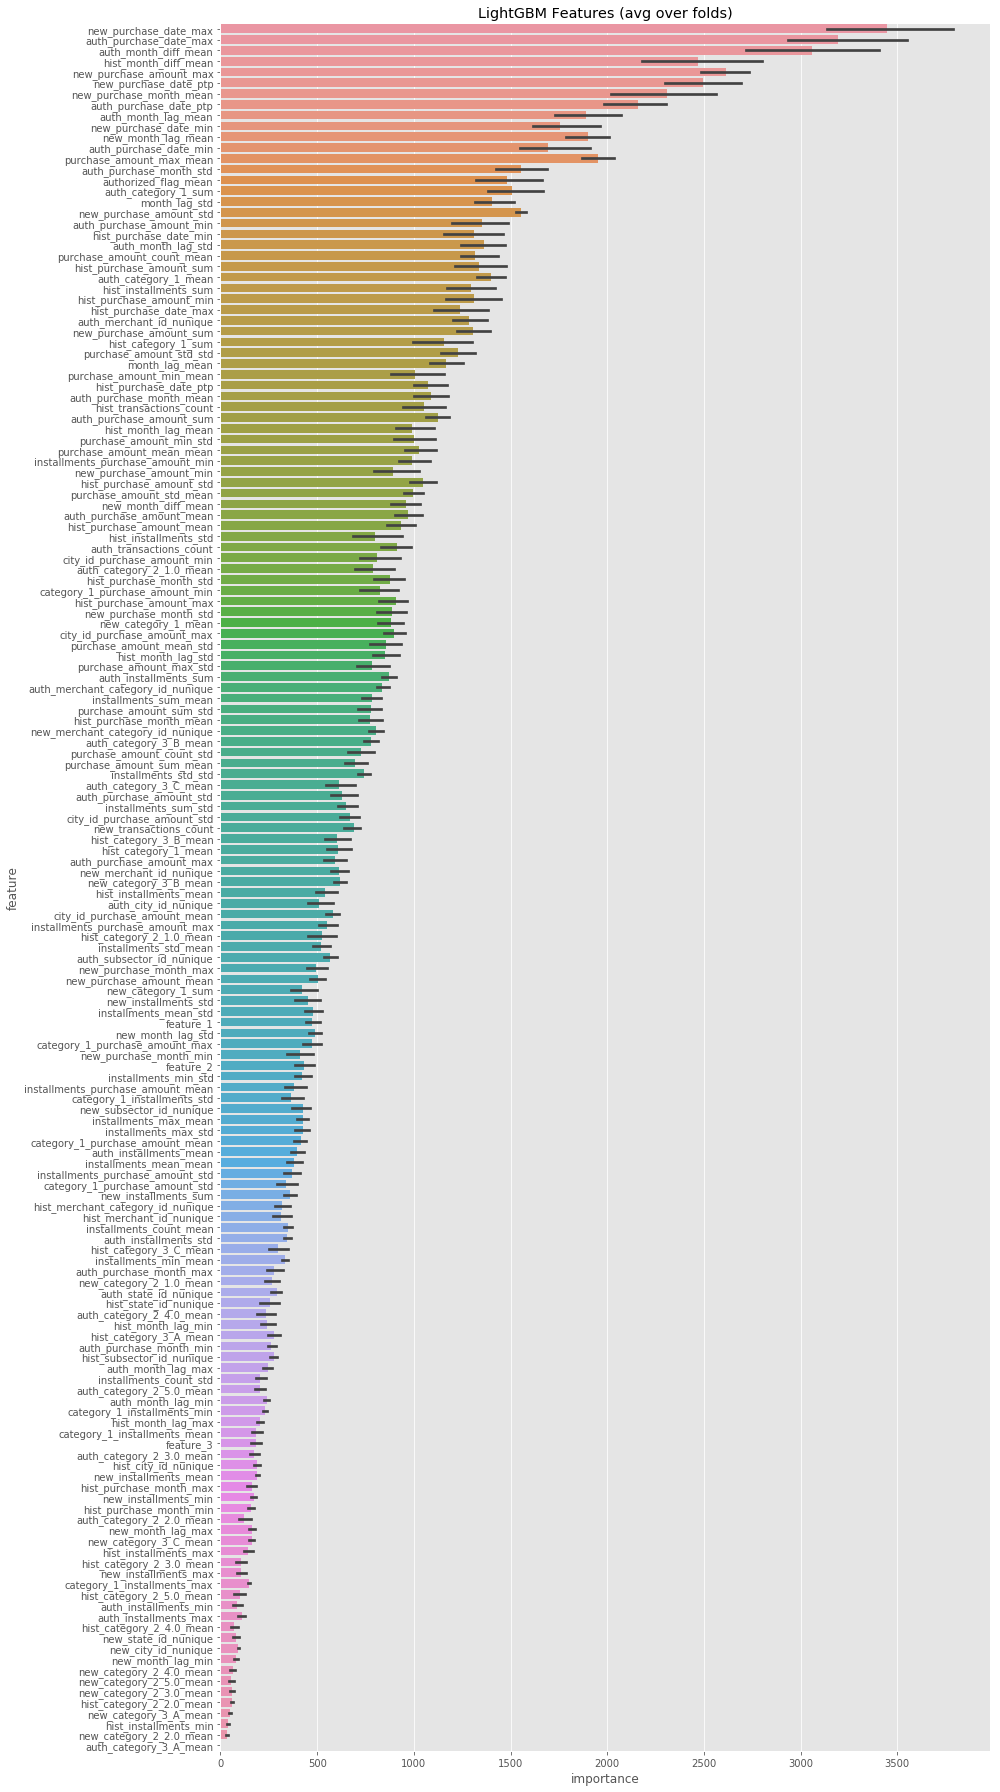

In [20]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [21]:
sub_df = pd.DataFrame({"card_id":test_df["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)